In [78]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

#%% Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataSciece.changeDirOnImportExport setting
import os
try:
    os.chdir(r'C:\Users\kevin\Documents\Workspace\psylit-experiments\src')
    print("Changed cwd:", os.getcwd())
except:
    print("cwd:", os.getcwd())

from IPython.display import display, Markdown, Latex
from collections import *
from statistics import mean
from functools import *
from os import linesep as EOL
from itertools import *
import re
import json

import spacy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import plotly as py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Changed cwd: C:\Users\kevin\Documents\Workspace\psylit-experiments\src


In [2]:
py.offline.init_notebook_mode()
plt.rcParams['figure.figsize'] = 16,10
np.random.seed(0)

In [177]:
book = 'greatex_100k'

ents = pd.read_csv(r'..\data\interim\{book}.ent.csv'.format(book=book), index_col=0)
df = pd.read_csv(r'..\data\interim\{book}.data.csv'.format(book=book), index_col=False)
meta = r'..\data\interim\{book}.meta.json'.format(book=book)

rel_cols = list(df.columns[list(df.columns.str.startswith('R_'))])
lex_cols = list(df.columns[list(df.columns.str.startswith('L_'))])
with open(meta) as f:
    meta_json = json.load(f)
meta_json

{'cmd': ['C:\\Users\\kevin\\Documents\\Workspace\\psylit-experiments\\src\\data_prepare.py',
  '-fx',
  '-t1',
  '100_000',
  '-r',
  'greatex_100k',
  'data\\raw\\EN_1861_Dickens,Charles_GreatExpectations_Novel.txt',
  'data\\interim'],
 'time': '2019-08-15T16:49:50.777970',
 'input_filename': 'data\\raw\\EN_1861_Dickens,Charles_GreatExpectations_Novel.txt',
 'run_name': 'greatex_100k',
 'time_read': '59.4153 ms',
 'time_init': '10851.2 ms',
 'time_process': '65330.3 ms'}

In [ ]:
def format_rel_cols(df):
    dfr = df[rel_cols]
    dfr = dfr.fillna('NONE')
    dfr = dfr.replace('NONE','')
    dfr = dfr.apply(lambda c: c.str.lower(), axis='columns')
    dfr = dfr.replace('','NONE')
    
    dfc = df.copy()
    dfc.loc[:,rel_cols] = dfr
    return dfc

data = df.drop_duplicates()
data = format_rel_cols(data)
data

In [ ]:
data = data.groupby(['t','R_agent','R_patient','lemma']).mean().reset_index()
#data[rel_cols] = data[rel_cols].replace('NONE', np.nan)
data

In [ ]:
display(Markdown('## Number of predicates per subsentence'))
data.groupby(['t']).i.count().value_counts()

In [ ]:
ents

In [ ]:
ent_counts = pd.concat([data[r] for r in rel_cols], axis='rows').replace('NONE',None).dropna().value_counts()
most_common = ent_counts.idxmax() # most common
print('most_common =', most_common)
ent_counts.plot.bar()
ent_counts.sort_values(ascending=False)[:10]

In [9]:
#ents[ents.categ == 'narrator']
data[data.R_agent.str.lower().str.match('my ([a-z]*)er')]

t    R_agent R_patient    lemma  L_NRCw_Em_anger  \
144   4072  my sister      NONE     time              0.0   
360   9296  my sister      NONE  general              0.0   
744  19975  my father      NONE      row              1.0   

     L_NRCw_Em_anticipation  L_NRCw_Em_disgust  L_NRCw_Em_fear  L_NRCw_Em_joy  \
144                     1.0                0.0             0.0            0.0   
360                     0.0                0.0             0.0            0.0   
744                     0.0                0.0             0.0            0.0   

     L_NRCw_Em_negative  L_NRCw_Em_positive  L_NRCw_Em_sadness  \
144                 0.0                 0.0                0.0   
360                 0.0                 1.0                0.0   
744                 1.0                 0.0                0.0   

     L_NRCw_Em_surprise  L_NRCw_Em_trust      i    neg  sent_i  
144                 0.0              0.0   4069  False    4067  
360                 0.0              1.0   9296  False    9285  
744                 0.0              0.0  19975  False   19961

In [361]:
def make_entity_lookup(ents, subject=None):
    ents_lookup = ents[['t0','entity_root', 'categ']].drop_duplicates()
    #ents_lookup.rename(index=str, columns={'entity_root': 'root', 'entity_name': 'name'}, inplace=True)
    #ents_lookup.set_index('entity_root', inplace=True, verify_integrity=True)
    
    is_narrator = ents_lookup.categ == 'narrator'
    is_reader = ents_lookup.categ == 'reader'

    if subject:
        is_subject = ents_lookup.entity_root == subject
    else:
        is_subject = is_narrator
        
    #ents_lookup.loc[narrator,'entity_root'] = 'NARRATOR'
    #ents_lookup.loc[reader,'entity_root'] = 'READER'

    ents_lookup.loc[is_narrator,'categ'] = 'person'
    ents_lookup.loc[is_reader,'categ'] = 'person'
    
    ents_lookup.loc[is_subject, 'categ'] = 'subject'
    
    ents_lookup.loc[is_subject, 'categ'] = 'subject'
    
    
    most_likely_categ = lambda fr: fr.categ.value_counts(normalize=True, ascending=False, dropna=False).idxmax()
    ents_lookup = ents_lookup.groupby('entity_root').apply(most_likely_categ)
    ents_lookup.name = 'ent_class'
    
    ents_lookup.loc['NONE'] = 'none'
    
    #ents_lookup.at['NARRATOR']
    return ents_lookup

subject = most_common
ents_lookup = make_entity_lookup(ents, subject=subject)
print(ents_lookup[ents_lookup == 'subject'])
ents_lookup[ents_lookup == 'person']

entity_root
i    subject
Name: ent_class, dtype: object


entity_root
NARRATOR        person
PERSON          person
READER          person
aunt            person
beast           person
biddy           person
blacksmith      person
boy             person
carols          person
child           person
clergyman       person
company         person
convict         person
convicts        person
creature        person
dike            person
dog             person
ends            person
he              person
her left        person
herself         person
him             person
j               person
joe             person
joe gargery     person
joe's           person
king            person
man             person
me              person
men             person
                 ...  
mr. wopsle's    person
mrs. hubble     person
mrs. joe        person
mum             person
my present      person
my unseen       person
nobody          person
o               person
party           person
pip             person
pip,"joe        person
pirate          person

In [11]:
display(Markdown('Entity type of entities starting with N'))
ents_lookup.loc[ents_lookup.index.str.startswith('N')]

Entity type of entities starting with N

entity_root
NARRATOR    person
NONE          none
Name: ent_class, dtype: object

In [12]:
display(Markdown('Entity type counts'))
ents_lookup[ents.entity_root].value_counts(dropna=False)

Entity type counts

unknown        1783
person         1587
environment     698
subject         406
NaN              11
Name: ent_class, dtype: int64

In [13]:
display(Markdown("Entities with type 'unknown'"))
ents.entity_root[(ents_lookup[ents.entity_root] == 'unknown').values].value_counts(dropna=False)

Entities with type 'unknown'

UNKNOWN       1722
they            21
them            16
roman           11
bear             3
went             2
young            2
born             2
asking           2
themselves       2
Name: entity_root, dtype: int64

In [14]:
display(Markdown("Entities without type"))
ents_lookup[ents_lookup.isna()]

Entities without type

entity_root
christmas day    NaN
constable        NaN
god              NaN
ope              NaN
Name: ent_class, dtype: object

In [386]:
def map_columns(data, cols, lookup, names=None, replace_cols=True):
    merged = data.copy()
    names = names or cols
    for col, col_new_name in zip(cols, names):
        merged_col = merged[[col]].merge(lookup, how='left', left_on=col, right_index=True)#, suffixes=suffixes)

        if replace_cols:
            merged.pop(col)
            
        merged[col_new_name] = merged_col[lookup.name]
        
    return merged

merged = map_columns(data, rel_cols, ents_lookup)
merged

t        lemma  L_NRCw_Em_anger  L_NRCw_Em_anticipation  \
0       51    authority              0.0                     0.0   
1      155     childish              0.0                     0.0   
2      164       sickly              0.0                     0.0   
3      226    entertain              0.0                     0.0   
4      301         find              0.0                     0.0   
5      301         time              0.0                     1.0   
6      588       terror              0.0                     0.0   
7      747         heel              0.0                     0.0   
8      783          eat              0.0                     0.0   
9      799         lick              0.0                     0.0   
10     841          eat              0.0                     0.0   
11     933        start              0.0                     1.0   
12     956      explain              0.0                     0.0   
13     972         come              0.0                     1.0   
14    1013       mutter              1.0                     0.0   
15    1138     question              0.0                     0.0   
16    1331         jump              0.0                     0.0   
17    1347      upright              0.0                     0.0   
18    1351          top              0.0                     1.0   
19    1354        stone              1.0                     0.0   
20    1366       morrow              0.0                     1.0   
21    1390      Battery              1.0                     0.0   
22    1401         dare              0.0                     1.0   
23    1436          eat              0.0                     0.0   
24    1499        Angel              0.0                     1.0   
25    1506         word              1.0                     0.0   
26    1513       secret              0.0                     0.0   
27    1543      attempt              0.0                     1.0   
28    1580         safe              0.0                     0.0   
29    1588        creep              0.0                     0.0   
..     ...          ...              ...                     ...   
797  21626         hope              0.0                     1.0   
798  21629  shortcoming              0.0                     0.0   
799  21646   admiration              0.0                     0.0   
800  21667        quiet              0.0                     0.0   
801  21681         time              0.0                     1.0   
802  21706         rise              0.0                     1.0   
803  21739         hope              0.0                     1.0   
804  21759   occasional              0.0                     0.0   
805  21759         trip              0.0                     0.0   
806  21768       assist              0.0                     0.0   
807  21783       repose              0.0                     0.0   
808  21789   confidence              0.0                     0.0   
809  21792      servant              0.0                     0.0   
810  21807   expedition              0.0                     1.0   
811  21811         fire              0.0                     0.0   
812  21811       hearth              0.0                     0.0   
813  21868        think              0.0                     1.0   
814  21876         star              0.0                     1.0   
815  21897        death              1.0                     1.0   
816  21956         fire              0.0                     0.0   
817  21956        ready              0.0                     1.0   
818  21996  preparation              0.0                     1.0   
819  22015        cover              0.0                     0.0   
820  22029         cold              0.0                     0.0   
821  22061        haste              0.0                     1.0   
822  22069   excitement              0.0                     1.0   
823  22174       motion              0.0                     1.0 

In [404]:
def per_entity_data(ents, data, take_top=10):
    ent_counts = pd.concat([data[r] for r in rel_cols], axis='rows').replace('NONE',None).dropna().value_counts()
    selected_ents = ent_counts.sort_values(ascending=False)[:take_top].index
    mapped = []
    for subject in selected_ents:
        ents_lookup = make_entity_lookup(ents, subject=subject)
        subj_data = map_columns(data, rel_cols, ents_lookup)
        subj_data['Subject'] = subject
        mapped.append(subj_data)
         
    return pd.concat(mapped, axis='rows').groupby('Subject')

all_data = per_entity_data(ents, data)

In [350]:
merged[merged.R_agent.isna() | merged.R_patient.isna()]

t       lemma  L_NRCw_Em_anger  L_NRCw_Em_anticipation  \
10     841         eat              0.0                     0.0   
39    1784         hug              0.0                     0.0   
48    1932         hug              0.0                     0.0   
67    2306       marry              0.0                     1.0   
207   5691      terror              0.0                     0.0   
234   6292        hang              1.0                     0.0   
242   6691        find              0.0                     0.0   
261   7030         hug              0.0                     0.0   
388  10021     present              0.0                     1.0   
425  11204       enjoy              0.0                     1.0   
426  11212     improve              0.0                     1.0   
650  17644   represent              0.0                     0.0   
659  17824   discovery              0.0                     0.0   
710  18905     confess              0.0                     0.0   
711  18927      orphan              0.0                     0.0   
770  20857       bless              0.0                     1.0   
771  20861       child              0.0                     1.0   
777  21127  government              0.0                     0.0   

     L_NRCw_Em_disgust  L_NRCw_Em_fear  L_NRCw_Em_joy  L_NRCw_Em_negative  \
10                 0.0             0.0            0.0                 0.0   
39                 0.0             0.0            1.0                 0.0   
48                 0.0             0.0            1.0                 0.0   
67                 0.0             1.0            1.0                 0.0   
207                0.0             1.0            0.0                 1.0   
234                1.0             1.0            0.0                 1.0   
242                0.0             0.0            1.0                 0.0   
261                0.0             0.0            1.0                 0.0   
388                0.0             0.0            1.0                 0.0   
425                0.0             0.0            1.0                 0.0   
426                0.0             0.0            1.0                 0.0   
650                0.0             0.0            0.0                 0.0   
659                0.0             0.0            0.0                 0.0   
710                0.0             0.0            0.0                 1.0   
711                0.0             1.0            0.0                 1.0   
770                0.0             0.0            1.0                 0.0   
771                0.0             0.0            1.0                 0.0   
777                0.0             1.0            0.0                 1.0   

     L_NRCw_Em_positive  L_NRCw_Em_sadness  L_NRCw_Em_surprise  \
10                  1.0                0.0                 0.0   
39                  1.0                0.0                 0.0   
48                  1.0                0.0                 0.0   
67                  1.0                0.0                 1.0   
207                 0.0                0.0                 0.0   
234                 0.0                1.0                 0.0   
242                 1.0                0.0                 0.0   
261                 1.0                0.0                 0.0   
388                 1.0                0.0                 1.0   
425                 1.0                0.0                 0.0   
426                 1.0                0.0                 0.0   
650                 1.0                0.0                 0.0   
659                 1.0                0.0                 0.0   
710                 1.0                0.0                 0.0   
711                 0.0                1.0                 0.0   
770                 1.0                0.0                 0.0   
771                 1.0                0.0                 0.0   
777                 0.0                0.0                 0.0   

     L_NRCw_Em_t

In [46]:
subject_mask = (merged.R_agent == 'subject') | (merged.R_patient == 'subject')
subject_rows = merged[subject_mask]
print(len(subject_rows), 'rows with subject')
subject_rows

178 rows with subject


t          lemma  L_NRCw_Em_anger  L_NRCw_Em_anticipation  \
0       51      authority              0.0                     0.0   
1      155       childish              0.0                     0.0   
2      164         sickly              0.0                     0.0   
3      226      entertain              0.0                     0.0   
10     841            eat              0.0                     0.0   
12     956        explain              0.0                     0.0   
31    1607           harm              0.0                     0.0   
32    1612        present              0.0                     1.0   
33    1617     difficulty              1.0                     0.0   
34    1673        Battery              1.0                     0.0   
36    1743         falter              0.0                     0.0   
41    1810           pick              0.0                     0.0   
42    1818         nettle              1.0                     0.0   
95    2799          treat              1.0                     1.0   
96    2803          large              0.0                     0.0   
97    2806          child              0.0                     1.0   
99    2868         advice              0.0                     0.0   
102   2949          young              0.0                     1.0   
103   2969           wear              0.0                     0.0   
104   2973           fret              0.0                     0.0   
105   2975         fright              0.0                     0.0   
106   3086        whimper              0.0                     0.0   
107   3162           fire              0.0                     0.0   
117   3530        present              0.0                     1.0   
118   3539           dare              0.0                     1.0   
119   3541            eat              0.0                     0.0   
120   3549        reserve              0.0                     0.0   
121   3562       dreadful              1.0                     1.0   
122   3563          young              0.0                     1.0   
125   3617           find              0.0                     0.0   
..     ...            ...              ...                     ...   
650  17644      represent              0.0                     0.0   
651  17662           feel              1.0                     1.0   
655  17762           word              0.0                     0.0   
656  17795    intercourse              0.0                     0.0   
657  17795           time              0.0                     1.0   
658  17807        imitate              0.0                     0.0   
659  17824      discovery              0.0                     0.0   
660  17826         action              0.0                     0.0   
665  17959           time              0.0                     1.0   
666  17999            aid              0.0                     0.0   
667  18009          thump              1.0                     0.0   
668  18012       shoulder              0.0                     0.0   
669  18016    restorative              0.0                     1.0   
670  18036           find              0.0                     0.0   
683  18298           read              0.0                     0.0   
684  18307           time              0.0                     1.0   
685  18343     exaltation              0.0                     0.0   
686  18368          doubt              0.0                     0.0   
687  18374            bad              1.0                     0.0   
688  18500         render              0.0                     0.0   
689  18508         happen              0.0                     1.0   
690  18513          forge              0.0                     0.0   
691  18513            boy              0.0                     0.0   
692  18588     impression              0.0                     0.0   
693  18610           hope              0.0                     1.0   
694  18610  partici

In [220]:
def get_cascades_for_entity(merged, subject):
    
    def cascade_representation(data, symbolic_cols, numeric_cols, symbolic_na=False, casc_index=['t']):
        sym_cascades = pd.get_dummies(data[symbolic_cols], dummy_na=symbolic_na)#, prefix_sep='+')
        #sym_cascades.columns = pd.MultiIndex.from_tuples((c.split('+') for c in symbolic_cols.columns), names=['grp','feat'])
        #sym_cols = sym_cascades.columns

        num_cascades = (data[numeric_cols] > data[numeric_cols].mean()) * 1
        #num_cascades.columns = pd.MultiIndex.from_tuples(
        #    (('predicate', c) for c in num_cascades.columns), names=['grp','feat'])
        casc = pd.concat([data[casc_index], sym_cascades, num_cascades], axis='columns')
        casc = casc.groupby(casc_index).any()*1

        return casc


    # Discard NaNs, negations and irrelevant columns
    keep = (~merged[rel_cols].isna()).any(axis='columns') & ~merged.neg.fillna(False)
    single_casc = merged[keep][['t','neg']+rel_cols+lex_cols]

    # Transform into cascades
    single_casc = cascade_representation(
                                    single_casc,
                                    symbolic_cols=rel_cols,
                                    numeric_cols=lex_cols)


    # Drop irrelevant columns
    irrelevant_cols = [col for col in single_casc.columns if col[1] in ('none',)]
    single_casc = single_casc.drop(irrelevant_cols, axis='columns')


    # Put all unknown into a single columns
    unk_cols = [c for c in single_casc.columns if c.endswith('unknown')]
    single_casc['R_unknown'] = single_casc[unk_cols].any(axis='columns').astype(int)
    single_casc.drop(unk_cols, axis='columns', inplace=True)

    return

R_agent_environment  R_agent_person  R_agent_subject  \
t                                                             
51                       0               0                1   
155                      0               0                1   
164                      0               0                1   
226                      0               0                1   
301                      0               1                0   
588                      0               1                0   
747                      1               0                0   
783                      0               1                0   
799                      0               1                0   
933                      0               1                0   
956                      0               0                1   
972                      0               1                0   
1013                     0               1                0   
1138                     0               1                0   
1331                     0               1                0   
1347                     0               1                0   
1351                     0               1                0   
1354                     0               1                0   
1366                     0               1                0   
1390                     0               1                0   
1436                     0               1                0   
1499                     0               1                0   
1506                     0               1                0   
1513                     0               1                0   
1543                     0               1                0   
1580                     0               1                0   
1588                     0               1                0   
1607                     0               0                1   
1612                     0               0                1   
1617                     0               0                1   
...                    ...             ...              ...   
21503                    0               1                0   
21508                    0               1                0   
21524                    0               1                0   
21626                    0               1                0   
21629                    0               1                0   
21646                    0               1                0   
21667                    0               1                0   
21681                    0               1                0   
21706                    0               1                0   
21739                    0               1                0   
21759                    0               1                0   
21768                    0               1                0   
21783                    1               0                0   
21789                    1               0                0   
21792                    1               0                0   
21807                    0               1                0   
21811                    0               1                0   
21868                    0               1                0   
21876                    0               1                0   
21897                    0               1                0   
21956                    0               1                0   
21996                    0               1                0   
22015                    1               0                0   
22029                    0               1                0   
22061                    0               1                0   
22069                    0               1                0   
22174                    0               0                1   
22191                    0               1                0   
22215                    0               1                0   
22251                    0               0                1   

       R_patient_environment  R_patie

In [256]:
def pair_cascades(casc, sources, destinations, name_fmt=(lambda src, dst: "{src} & {dst}")):
    pairs = list(product(sources, destinations))
    return pd.DataFrame({
        name_fmt(s, d): casc[s] * casc[d]
        for s, d in pairs})

# Compute combinations with entity roles
pairs_casc = single_casc.copy()
unk = pairs_casc.pop('R_unknown')
pairs_casc = pair_cascades(pairs_casc, 
                           [c for c in pairs_casc.columns if c.startswith('R_')],
                           [c for c in pairs_casc.columns if c.startswith('L_')],
                           name_fmt=lambda src, dst: f"{src[2:]} {dst[10:]}".replace('_',' ').title())
pairs_casc['unknown'] = unk

pairs_casc

Agent Environment Anger  Agent Environment Anticipation  \
t                                                                
51                           0                               0   
155                          0                               0   
164                          0                               0   
226                          0                               0   
301                          0                               0   
588                          0                               0   
747                          0                               0   
783                          0                               0   
799                          0                               0   
933                          0                               0   
956                          0                               0   
972                          0                               0   
1013                         0                               0   
1138                         0                               0   
1331                         0                               0   
1347                         0                               0   
1351                         0                               0   
1354                         0                               0   
1366                         0                               0   
1390                         0                               0   
1436                         0                               0   
1499                         0                               0   
1506                         0                               0   
1513                         0                               0   
1543                         0                               0   
1580                         0                               0   
1588                         0                               0   
1607                         0                               0   
1612                         0                               0   
1617                         0                               0   
...                        ...                             ...   
21503                        0                               0   
21508                        0                               0   
21524                        0                               0   
21626                        0                               0   
21629                        0                               0   
21646                        0                               0   
21667                        0                               0   
21681                        0                               0   
21706                        0                               0   
21739                        0                               0   
21759                        0                               0   
21768                        0                               0   
21783                        0                               0   
21789                        0                               0   
21792                        0                               0   
21807                        0                               0   
21811                        0                               0   
21868                        0                               0   
21876                        0                               0   
21897                        0                               0   
21956                        0                               0   
21996                        0                               0   
22015                        0                               0   
22029                        0                               0   
22061                        0                               0   
22069                        0                               0   
22174                        0                               0   
22191                        0                 

In [273]:
casc = pairs_casc.copy()
response_ident = 'Agent Subject'
stim_prefix = "[S] "
resp_prefix = "[R] "
new_names = {
    c: resp_prefix+c.replace(response_ident, '') if c.startswith(response_ident) else stim_prefix+c 
    for c in casc.columns
}
casc.rename(index=str, columns=new_names, inplace=True)
stim_cols = [c for c in casc.columns if c.startswith(stim_prefix)]
resp_cols = [c for c in casc.columns if c.startswith(resp_prefix)]
#casc.columns = pd.MultiIndex.from_tuples(
#    tuple([('Response' if c.startswith('Agent Subject') else 'Stimulus'), *c.split()][::-1])
#    for c in casc.columns
#)
#casc.T.groupby(level=[3,0]).any().astype(int).T


In [258]:
import plotly as py
import plotly.graph_objs as go

def get_traces(casc):
    ent_casc_cols = [c for c in casc.columns if not c.startswith('L_')]
    for ecol in ent_casc_cols:
        if ecol not in casc.columns:
            print('Ignoring col', ecol)
            continue
        mask = casc[lex_cols][casc[ecol] == 1] == 1
        trace_data = [(c, mask.index[mask[c]]) for c in lex_cols]
        #trace_data = np.array([[v.to_numpy(), [k]*len(v)] for k, v in trace_data.items()])
        #print(trace_data.shape)
        #return trace_data
        x = np.concatenate([idx.to_numpy() for c, idx in trace_data])
        y = np.concatenate([[c]*len(idx)   for c, idx in trace_data])
        yield go.Scattergl({
            "x": x,
            "y": y, 
            "marker": {"opacity": 0.75}, 
            "hoverinfo": "text",
            #"text": txt,
            "mode": "markers", 
            "name": ecol, 
            "type": "scatter"
        })
        
traces = list(get_traces(casc))
layout = {"title": "", 
          "xaxis": {"title": "", }, 
          "yaxis": {"title": ""}}

fig = go.Figure(data=traces)
py.offline.iplot(fig)

KeyError: "None of [Index(['L_NRCw_Em_anger', 'L_NRCw_Em_anticipation', 'L_NRCw_Em_disgust',\n       'L_NRCw_Em_fear', 'L_NRCw_Em_joy', 'L_NRCw_Em_negative',\n       'L_NRCw_Em_positive', 'L_NRCw_Em_sadness', 'L_NRCw_Em_surprise',\n       'L_NRCw_Em_trust'],\n      dtype='object')] are in the [columns]"

In [ ]:
from scipy.stats import ttest_ind
    
ttest_ind(
    casc.loc[casc['patient_subject'] == 1, lex_cols],
    casc[lex_cols].mean(),
    #casc.loc[casc['agent_person'] == 1, lex_cols],
)

In [201]:
#casc.sum().plot(kind='barh')
sns.barplot(data=casc, x)

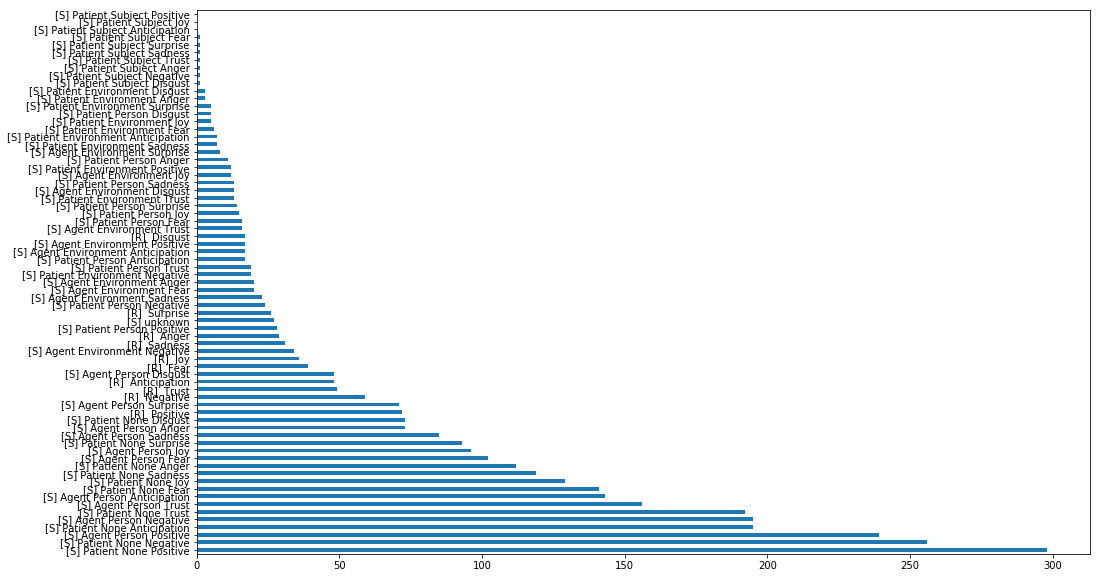

In [274]:
#higher_casc = higher_casc.loc[:, higher_casc.sum() > 15]
casc.sum().sort_values(ascending=False).plot(kind='barh')

In [297]:
from pyinform import transferentropy as te

def transfer_entropies(casc, source_cols=None, destination_cols=None, traj_col=None, **kwargs):
    all_cols = list(casc.columns)
    source_cols = source_cols or all_cols
    destination_cols = destination_cols or all_cols
    
    rows = []
    for sc in source_cols:
        row = {'source': sc, 
               **{dc:te.transfer_entropy(casc[sc], casc[dc], **kwargs) for dc in destination_cols }}
        rows.append(row)
    df = pd.DataFrame(rows)
    df.set_index('source', inplace=True, verify_integrity=True)
    return df


k = 10
T = transfer_entropies(casc, k=k)
T

[R]  Anger  [R]  Anticipation  \
source                                                              
[S] Agent Environment Anger           0.001114           0.001216   
[S] Agent Environment Anticipation    0.000837           0.001546   
[S] Agent Environment Disgust         0.008048           0.000654   
[S] Agent Environment Fear            0.008282           0.000624   
[S] Agent Environment Joy             0.000879           0.001149   
[S] Agent Environment Negative        0.002041           0.001973   
[S] Agent Environment Positive        0.001471           0.001375   
[S] Agent Environment Sadness         0.001484           0.001331   
[S] Agent Environment Surprise        0.000524           0.001079   
[S] Agent Environment Trust           0.001353           0.001318   
[S] Agent Person Anger                0.004189           0.007305   
[S] Agent Person Anticipation         0.008940           0.011873   
[S] Agent Person Disgust              0.000207           0.000266   
[S] Agent Person Fear                 0.006337           0.008335   
[S] Agent Person Joy                  0.005267           0.002640   
[S] Agent Person Negative             0.004077           0.009202   
[S] Agent Person Positive             0.008411           0.019116   
[S] Agent Person Sadness              0.001262           0.004468   
[S] Agent Person Surprise             0.004166           0.000924   
[S] Agent Person Trust                0.004516           0.006273   
[R]  Anger                            0.000000           0.006246   
[R]  Anticipation                     0.018092           0.000000   
[R]  Disgust                          0.010404           0.008027   
[R]  Fear                             0.010613           0.008788   
[R]  Joy                              0.011300           0.005432   
[R]  Negative                         0.010753           0.017740   
[R]  Positive                         0.017822           0.024853   
[R]  Sadness                          0.014382           0.006427   
[R]  Surprise                         0.010428           0.006276   
[R]  Trust                            0.019717           0.015268   
...                                        ...                ...   
[S] Patient None Anticipation         0.006329           0.021244   
[S] Patient None Disgust              0.007217           0.004756   
[S] Patient None Fear                 0.011452           0.015695   
[S] Patient None Joy                  0.002887           0.006505   
[S] Patient None Negative             0.007513           0.017058   
[S] Patient None Positive             0.004989           0.015822   
[S] Patient None Sadness              0.006724           0.008041   
[S] Patient None Surprise             0.008751           0.008795   
[S] Patient None Trust                0.005671           0.015428   
[S] Patient Person Anger              0.001624           0.003854   
[S] Patient Person Anticipation       0.001519           0.001868   
[S] Patient Person Disgust            0.000846           0.000678   
[S] Patient Person Fear               0.004811           0.004326   
[S] Patient Person Joy                0.001206           0.001204   
[S] Patient Person Negative           0.005135           0.001602   
[S] Patient Person Positive           0.001884           0.002371   
[S] Patient Person Sadness            0.001814           0.001015   
[S] Patient Person Surprise           0.001885           0.001204   
[S] Patient Person Trust              0.001541           0.001431   
[S] Patient Subject Anger             0.000060           0.000055   
[S] Patient Subject Anticipation      0.000000           0.000000   
[S] Patient Subject Disgust           0.000060           0.000055   
[S] Patient Subject Fear              0.000060           0.000055   
[S] Patient Subject Joy               0.000000           0.000000   
[S] Patient Subject Negative          0.000060           0.000055   
[S] Patient Subject Positive      

In [284]:
seq_cmap = sns.choose_colorbrewer_palette('sequential')

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

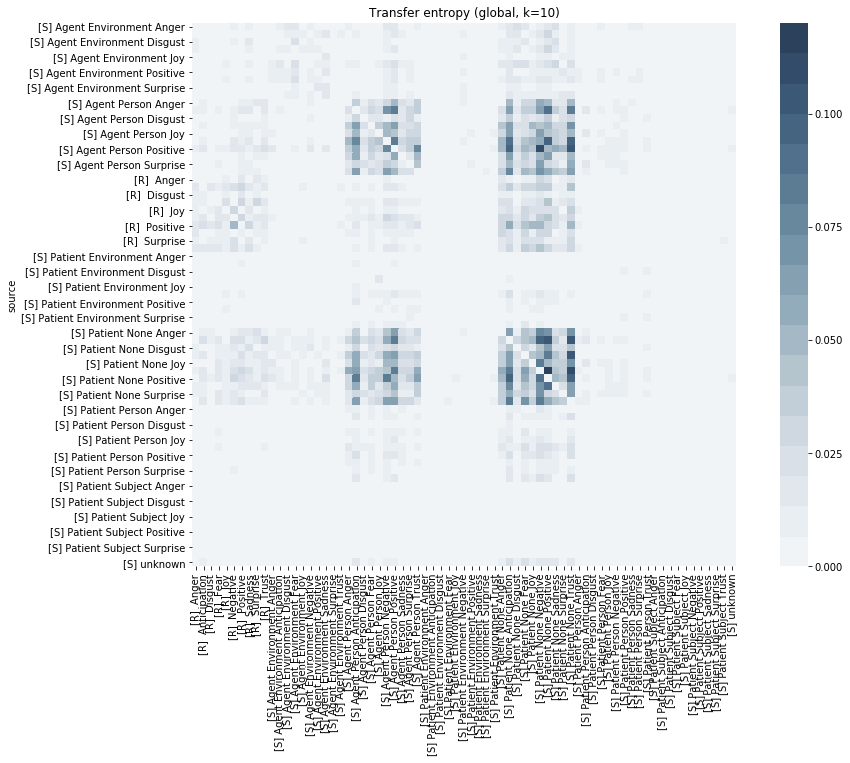

In [298]:
import plotly.figure_factory as ff
#x = te_1.index
#y = te_1.destination

#fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text)#, colorscale='Viridis')
sns.heatmap(T, annot=False, cmap=seq_cmap, square=True)
plt.title(f"Transfer entropy (global, k={k})")
plt.show()

## Directionality (global, k=10, subject='i') : positive = driving, negative = driven

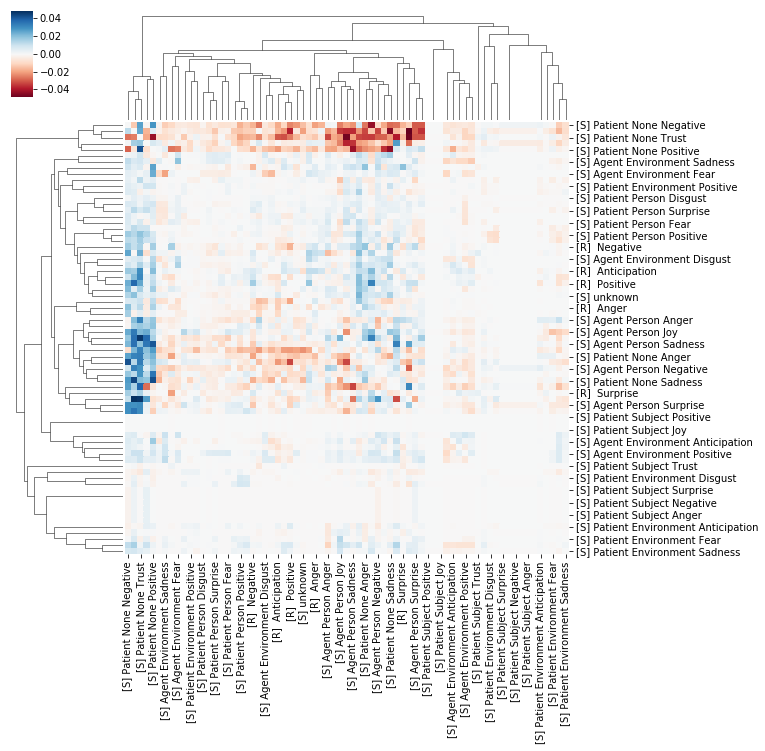

In [299]:
#sns.heatmap((T - T.T), annot=False, cmap='RdBu')#, fmt="d")
sns.clustermap((T - T.T), annot=False, cmap='RdBu', metric='cosine')#, fmt="d")

display(Markdown(f"## Directionality (global, k={k}, subject={subject!r}) : positive = driving, negative = driven"))
plt.show()

## Directionality: relevant subset (global, k=10, subject='i') : positive = driving, negative = driven

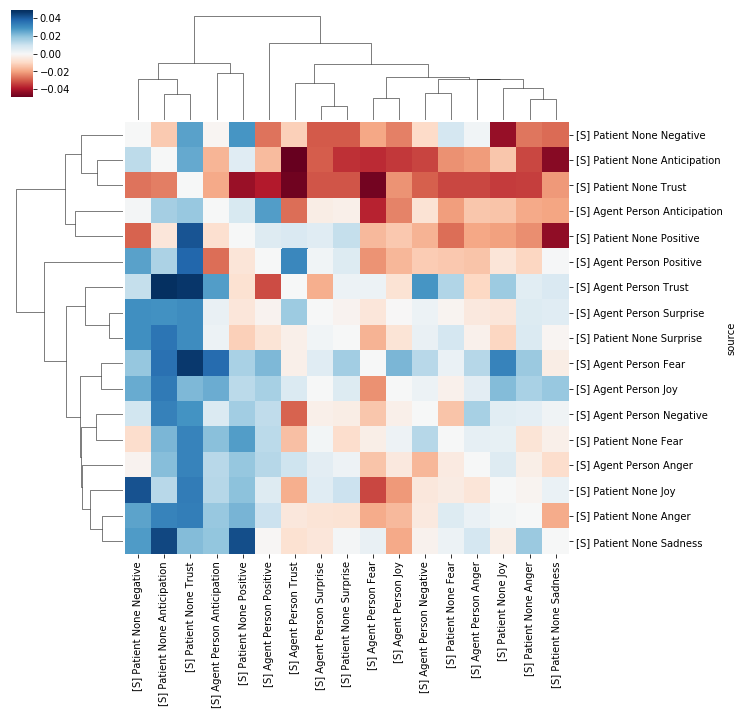

In [300]:
T_sumsq = T.apply(lambda x: x.pow(2).sum())
T_mask = T_sumsq > T_sumsq.mean()
T_core = T.loc[T_mask, T_mask]
sns.clustermap((T_core - T_core.T), annot=False, cmap='RdBu', metric='cosine')#, fmt="d")

display(Markdown(f"## Directionality: relevant subset (global, k={k}, subject={subject!r}) : positive = driving, negative = driven"))
plt.show()

In [302]:
def group_T(T, func, agg='sum', col_name=None):
    col_name = col_name or agg.title()
    T_core = T.copy().reset_index()
    T_core[col_name] = func(T_core.source)
    T_core = T_core.groupby(col_name).agg(agg)
    T_core = T_core.T.reset_index()
    T_core[col_name] = func(T_core['index'])
    T_core = T_core.groupby(col_name).agg(agg)
    return T_core

## Directionality per system (global, k=10, subject='i') : positive = driving, negative = driven

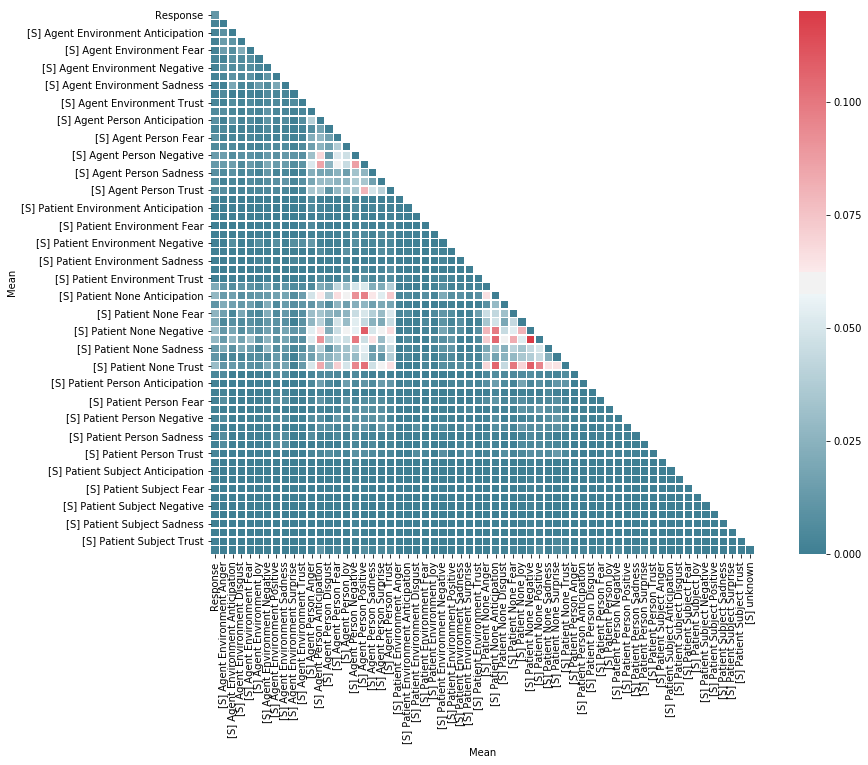

In [331]:
get_ent_role = lambda col: col.str.split(' & ', expand=True)[0]
get_ent = lambda col: col.str.split(' & ', expand=True)[0].str.split('_', expand=True)[1]
get_role = lambda col: col.str.split(' & ', expand=True)[0].str.split('_', expand=True)[0]
get_feat = lambda col: col.str.split(' & ', expand=True)[1]
get_sys = lambda col: np.where(col.str.startswith('[S]'), col, 'Response')#.apply(lambda is_s: [col, 'Response'][is_s]).astype(str) #.str.startswith('Agent Subject').apply(lambda r: ['[Stim] ', '[Resp] '][r]).astype(str) + col.str.split(' & ', expand=True)[1].astype(str)
    #lambda r: ['Stimulus', 'Response'][r[0] == 'agent_subject'] + ' ' + r[1])

def grouped_transfer_entropy_plot(T, T_group_func, grouping_title):
    title = (f"Directionality {grouping_title} (global, k={k}, subject={subject!r}) : positive = driving, negative = driven")
    display(Markdown(f"## {title}"))
    T_core = group_T(T, T_group_func, agg='mean')
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(T_core, dtype=np.bool)
    mask[np.triu_indices_from(mask, +1)] = True
    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    g = sns.heatmap((T_core), annot=False, cmap=cmap, mask=mask, square=True, linewidths=.6)
    #g = sns.clustermap((T_core), annot=False, cmap=cmap, mask=mask, metric='cosine', square=True)
    plt.show()

grouped_transfer_entropy_plot(T, get_sys, "per system")
#grouped_transfer_entropy_plot(T, get_ent, "per entity")
#grouped_transfer_entropy_plot(T, get_role, "per role")
#grouped_transfer_entropy_plot(T, get_ent_role, "per entity and role")
#grouped_transfer_entropy_plot(T, get_feat, "per feature")


In [307]:
from pyinform import blockentropy as be
def get_block_entropies(casc, cols, kmax=10):
    n = len(casc.index)
    
    data = []
    for k in range(1, kmax):
        for c in cols:
            benk = be.block_entropy(casc[c], k=k)
            data.append({'k': k, 'cascade': c, 'block_entropy_k': benk})
    
    return pd.DataFrame(data)

block_entrs = get_block_entropies(higher_casc, all_cols, kmax=30)

KeyError: 'Agent Environment Anger'

In [ ]:
#sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='cascade')
#plt.show()

In [ ]:
block_entrs['block_entropy_k_diff'] = block_entrs.block_entropy_k.diff()
block_entrs[['ent_role','feat']] = block_entrs.cascade.str.split(' & ',expand=True)
block_entrs[['role','entity']] = block_entrs.ent_role.str.split('_',expand=True)
block_entrs['block_entropy_k_ratio'] = block_entrs.block_entropy_k / block_entrs.k
block_entrs['block_entropy_k_ratio_diff'] = block_entrs['block_entropy_k_ratio'].diff()
#block_entrs['f'] = block_entrs.cascade.str.split(' & ')[1]

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='ent', ax=axes[0][0])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='role', ax=axes[0][1])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='ent_role', ax=axes[1][0])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k', hue='feat', ax=axes[1][1])
fig.suptitle('Block entropy vs history length')
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_ratio', hue='ent', ax=axes[0][0])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_ratio', hue='role', ax=axes[0][1])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_ratio', hue='ent_role', ax=axes[1][0])
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_ratio', hue='feat', ax=axes[1][1])
fig.suptitle('Block entropy relative to history length')
plt.show()

In [ ]:
sns.lineplot(data=block_entrs, x='k', y='block_entropy_k_diff', hue='e')
plt.show()

In [ ]:
from pyinform import activeinfo as ai

def get_local_ais(casc, cols, k=10):
    n = len(casc.index)
    m = len(cols)
    t = np.tile(np.arange(n), m)
    
    lbl = np.repeat(np.array(cols), n)
    a = []
    pad_w = k-1
    a_c = np.ones([n]) * np.nan
    for c in cols:
        a_c[:-k] = ai.active_info(casc[c], k=k, local=True).squeeze()
        a.append(a_c)
    a = np.concatenate(a)
    
    df = pd.DataFrame({'ais': a, 'cascade': lbl, 't':t})
    df[['e','f']] = df.cascade.str.split(' & ',expand=True)
    return df

ais = get_local_ais(higher_casc, all_cols, k=11)
ais

In [ ]:
fig = lambda:go.Figure(
    data=[go.Scattergl(
        x=ais.t,
        y=ais.ais,
        marker=dict(color=ais.f),
        #line=dict(color='rgb(0,100,80)'),
        #line=dict(color=color),
        mode='markers',
        name=dict(color=ais.f),
    )],
)
#py.offline.iplot(fig)
#fig, ax = plt.subplots()
sns.scatterplot(data=ais.groupby('t').mean().reset_index(), x='t', y='ais', hue='e', ax=ax)
#py.offline.plot_mpl(fig)
#ais.groupby('e',.rolling(20, by='t').agg(['mean','min','max'])

In [ ]:
from plotly.colors import DEFAULT_PLOTLY_COLORS
#sns.lineplot(data=ais[ais.t < 200], x='t', y='ais', hue='e')
#plt.show()
ais_ts = ais.groupby('f').rolling(5).agg(['mean', 'min', 'max'])

def filled_plot(data, x, y, group, rolling_size=20, **kwargs):
    
    
    X = data.groupby(group)
    X = X.rolling(rolling_size, on=x)
    X = X.agg({y:['mean', 'min', 'max']})
    X.columns = X.columns.to_flat_index()
    #X.reset_index(level=['e','f'])
    
    
    
    data = [
        p
        for (gname, gframe), color in zip(X.groupby(group), DEFAULT_PLOTLY_COLORS)
        for p in filled_line(gframe, name=gname, color=color)
    ]       
    
    
    #X = X.unstack(['e','f'])
    #X.loc[('agent_environment','L_NRCw_Em_negative'),[('ais','mean')]]
    
    grouped = data.groupby(group)
    rolled = grouped.rolling(rolling_size)
    agg = rolled.agg({'t': 'mean', 'ais':['mean', 'min', 'max']})
    agg.columns = agg.columns.to_flat_index()
    
    trend = agg['ais', 'mean']
    x = agg['t', 'mean']
    x_rev = x.iloc[::-1]
    y = ['ais', 'mean']
    y_lb = ['ais', 'min']
    y_ub = ['ais', 'max']
    
    def filled_line(frame, color, name=None, **kwargs):
        
        filled = lambda:go.Scattergl(
            x=x + x.iloc[::-1],
            y=pd.concat([y['min'], y['max']]),
            fill='tozerox',
            fillcolor=color,
            #line=dict(color='rgba(255,255,255,0)'),
            #showlegend=False,
            opacity=0.2,
            name=name,
            **kwargs,
        )
        return [
            #filled,
            go.Scattergl(
                x=x,
                y=y['mean'],
                #line=dict(color='rgb(0,100,80)'),
                line=dict(color=color),
                mode='lines',
                name=name,
                **kwargs,
            ),
        ] 
    
    return go.Figure(
        #data=data,
        #layout=layout,
        data=[
            p
            for (gname, gframe, win_), color in zip(grouped, DEFAULT_PLOTLY_COLORS)
            for p in filled_line(gframe, x=x, y=y, name=gname, color=color)
        ]
    )
    
#fig = filled_plot(ais_ts, x='t', y='ais', group='cascade')

#fig = filled_plot(data=ais[ais.t < 200], x='t', y='ais', group='cascade')
#py.offline.iplot(fig)
#for gn, gf in 
#sns.lineplot(data=ais.rolling(20).mean(), x='t', y='ais', hue='e')
#plt.show()
#sns..plot(x='t', y='ais',kind='line')

rolling_size = 20
grouped = ais.groupby(['e','f'])
rolled = grouped.rolling(rolling_size)
trend = rolled['ais'].mean()
x = rolled['t'].mean()
x_rev = x.iloc[::-1]

In [ ]:
X = ais.groupby(['e','f'])
#X = X.reset_index()
X = X.rolling(20, on='t')
trend = X.ais.mean()
X = X.agg({'ais':['mean', 'min', 'max']})
X.columns = X.columns.to_flat_index()
X.apply(lambda s: s - trend, axis='columns')
#X = X.unstack(['e','f'])
#X.loc[:,[('ais','mean')]]
#X.reset_index(level)
##['t','mean']
#X['agent_environment', 'L_NRCw_Em_negative']['t','mean']
#g = grouped.rolling(20)
#g.index[:2]#e, f, win = g.index
#g['t','mean']['patient_person', 'L_NRCw_Em_trust']#[['t','mean']]#,'ais']
#for k,x in g.iterrows():
#    print(k,x)
    #print(gf.describe())
#for x in g[[('t', 'mean'), 'ais']]:
    #print(x)
    #continue
    #print(gn)
    #print(gf[[('t', 'mean'), 'ais']].describe())

In [ ]:
#sns.g
g = grouped.rolling(20)
sns.lineplot(data=g.agg({'t': 'mean', 'ais':['mean', 'min', 'max']}), 
             x=('t', 'mean'), y=('ais', 'mean'), hue=g.index)
plt.show()

In [ ]:
sns.lineplot(data=ais, x='t', y='ais')

In [ ]:
py.offline.plot_mpl?

In [ ]:
spacy.util.minibatch?

In [ ]:
list.pop?

In [ ]:
[].append

In [ ]:
[].push

In [ ]:
[].pop

In [ ]:
import spacy
spacy.__version__

In [ ]:
a = []
a.extend((range(3)))
a.extend((range(4,7)))
print(a)
a.pop(0), a.pop(0), a

In [ ]:
doc

In [72]:
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\kevin\\AppData\\Local\\conda\\conda\\envs\\tic-psy2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [175]:
"{x} {x[1:]}".format(x="hello")

TypeError: string indices must be integers

In [406]:
import sys
sys.cwd

AttributeError: module 'sys' has no attribute 'cwd'

In [20]:
ents.columns

Index(['categ', 'entity_i', 'entity_pos', 'entity_root', 'entity_tag',
       'entity_text', 'i', 'mention_pos', 'mention_root', 'mention_tag',
       'mention_text', 't0', 't1'],
      dtype='object')

In [31]:
sizes = (
    ents[~ents.entity_root.isin({'ENVIRONMENT', 'UNKNOWN', 'PERSON'})]
    .groupby(['entity_i','entity_root'])
    .size()
)
sizes.sort_values(ascending=False)#[sizes > 30].index.values

entity_i  entity_root      
9.0       NARRATOR             141
1367.0    joe                  136
1485.0    man                   98
582.0     sir                   86
730.0     joe                   53
1978.0    NARRATOR              51
3146.0    man                   45
1089.0    aunt                  43
1849.0    NARRATOR              40
2311.0    joe                   40
3523.0    NARRATOR              37
1556.0    joe                   33
3899.0    man                   33
861.0     uncle pumblechook     33
2119.0    man                   29
752.0     sergeant              26
457.0     NARRATOR              26
1027.0    NARRATOR              22
2620.0    mrs. joe              22
152.0     NARRATOR              20
4151.0    NARRATOR              20
2656.0    boy                   20
403.0     joe                   19
927.0     sir                   18
543.0     joe                   17
93.0      mr. pumblechook       17
1641.0    joe                   16
19.0      NARRATOR         

In [67]:
from src.data.lexicons import load_nrc_vad

VAD = load_nrc_vad()

In [68]:
VAD.describe()

valence       arousal     dominance
count  20006.000000  20006.000000  20006.000000
mean       0.500020      0.499976      0.500167
std        0.215691      0.171085      0.169843
min        0.000000      0.046000      0.045000
25%        0.347000      0.375000      0.375000
50%        0.510000      0.480000      0.482000
75%        0.653000      0.612000      0.620000
max        1.000000      0.990000      0.991000

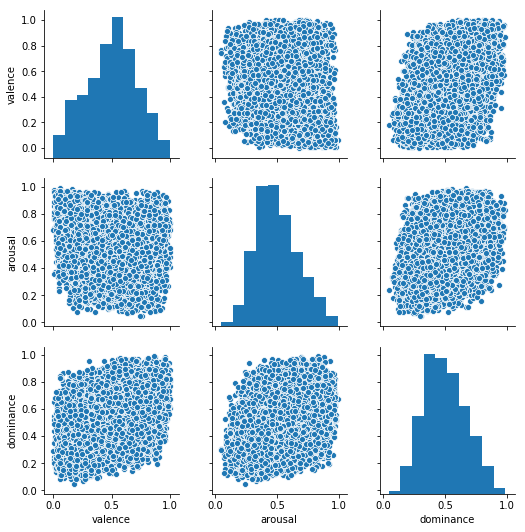

In [72]:
sns.pairplot(VAD)

In [92]:
from features.gen_cascades import MANUAL_RESOLUTION_LOOKUP

In [94]:
from features.entities import EXCEPTIONS as ENTITY_MANUAL_RESOLUTION
ENTITY_MANUAL_RESOLUTION

{'this': 'ENVIRONMENT',
 'something': 'ENVIRONMENT',
 'it': 'ENVIRONMENT',
 'itself': 'ENVIRONMENT',
 'that': 'ENVIRONMENT',
 'its': 'ENVIRONMENT',
 'those': 'UNKNOWN',
 'these': 'UNKNOWN',
 'they': 'UNKNOWN',
 'their': 'UNKNOWN',
 'themselves': 'UNKNOWN',
 'them': 'UNKNOWN',
 'my': 'NARRATOR',
 'ours': 'NARRATOR',
 'me': 'NARRATOR',
 'ourselves': 'NARRATOR',
 'we': 'NARRATOR',
 'i': 'NARRATOR',
 'mine': 'NARRATOR',
 'myself': 'NARRATOR',
 'us': 'NARRATOR',
 'our': 'NARRATOR',
 'yourself': 'READER',
 'your': 'READER',
 'you': 'READER',
 'yours': 'READER',
 'miss': 'PERSON',
 'herself': 'PERSON',
 'himself': 'PERSON',
 'she': 'PERSON',
 'her': 'PERSON',
 'hers': 'PERSON',
 'girl': 'PERSON',
 'boy': 'PERSON',
 'madam': 'PERSON',
 'his': 'PERSON',
 'woman': 'PERSON',
 'him': 'PERSON',
 'sir': 'PERSON',
 'lord': 'PERSON',
 'man': 'PERSON',
 'he': 'PERSON',
 'lady': 'PERSON'}

In [97]:
MANUAL_RESOLUTION_LOOKUP = pd.Series(ENTITY_MANUAL_RESOLUTION)
MANUAL_RESOLUTION_LOOKUP.update(pd.Series({v: v for v in ENTITY_MANUAL_RESOLUTION.values()}))
MANUAL_RESOLUTION_LOOKUP.name = 'ent_class'

In [114]:
MANUAL_RESOLUTION_LOOKUP

this          ENVIRONMENT
something     ENVIRONMENT
it            ENVIRONMENT
itself        ENVIRONMENT
that          ENVIRONMENT
its           ENVIRONMENT
those             UNKNOWN
these             UNKNOWN
they              UNKNOWN
their             UNKNOWN
themselves        UNKNOWN
them              UNKNOWN
my               NARRATOR
ours             NARRATOR
me               NARRATOR
ourselves        NARRATOR
we               NARRATOR
i                NARRATOR
mine             NARRATOR
myself           NARRATOR
us               NARRATOR
our              NARRATOR
yourself           READER
your               READER
you                READER
yours              READER
miss               PERSON
herself            PERSON
himself            PERSON
she                PERSON
her                PERSON
hers               PERSON
girl               PERSON
boy                PERSON
madam              PERSON
his                PERSON
woman              PERSON
him                PERSON
sir         

In [102]:
from features.gen_cascades import make_entity_lookup
from utils.pandas import df_map_columns
rel_cols = [c for c in df.columns if c.startswith('R_')]
lex_cols = [c for c in df.columns if c.startswith('L_')]
relevant_data_columns = ['t', 'neg'] + rel_cols + lex_cols
data = df[relevant_data_columns]

data = df_map_columns(data, rel_cols, MANUAL_RESOLUTION_LOOKUP)
ents2 = df_map_columns(ents, ['entity_root'], MANUAL_RESOLUTION_LOOKUP)

ents_lookup = make_entity_lookup(ents2)

characters = ents2[~ents2.entity_root.isin({'ENVIRONMENT', 'UNKNOWN', 'PERSON'})]

In [119]:
ents#.groupby(['entity_root','categ']).size().sort_values(ascending=False)

categ  entity_i entity_pos        entity_root entity_tag  \
0        unknown       NaN        NaN            UNKNOWN        NaN   
1        unknown       NaN        NaN            UNKNOWN        NaN   
2        unknown       NaN        NaN            UNKNOWN        NaN   
3        unknown       NaN        NaN            UNKNOWN        NaN   
4        unknown       NaN        NaN            UNKNOWN        NaN   
5        unknown       NaN        NaN            UNKNOWN        NaN   
6        unknown       NaN        NaN            UNKNOWN        NaN   
7        unknown       NaN        NaN            UNKNOWN        NaN   
8        unknown       NaN        NaN            UNKNOWN        NaN   
9        unknown       NaN        NaN            UNKNOWN        NaN   
10       unknown       NaN        NaN            UNKNOWN        NaN   
11        person       NaN        NaN             PERSON        NaN   
12       unknown       NaN        NaN            UNKNOWN        NaN   
13       unknown       NaN        NaN            UNKNOWN        NaN   
14       unknown       NaN        NaN            UNKNOWN        NaN   
15       unknown       NaN        NaN            UNKNOWN        NaN   
16       unknown       NaN        NaN            UNKNOWN        NaN   
17       unknown       NaN        NaN            UNKNOWN        NaN   
18       unknown       NaN        NaN            UNKNOWN        NaN   
19       unknown       NaN        NaN            UNKNOWN        NaN   
20       unknown       NaN        NaN            UNKNOWN        NaN   
21       unknown       NaN        NaN            UNKNOWN        NaN   
22       unknown       NaN        NaN            UNKNOWN        NaN   
23       unknown       NaN        NaN            UNKNOWN        NaN   
24       unknown       NaN        NaN            UNKNOWN        NaN   
25   environment       NaN        NaN        ENVIRONMENT        NaN   
26       unknown       NaN        NaN            UNKNOWN        NaN   
27       unknown       NaN        NaN            UNKNOWN        NaN   
28       unknown       NaN        NaN            UNKNOWN        NaN   
29   environment       NaN        NaN        ENVIRONMENT        NaN   
..           ...       ...        ...                ...        ...   
888  environment    4018.0      PROPN  uncle pumblechook        NNP   
889       person    4131.0       NOUN              stars        NNS   
890       person    4131.0       NOUN              stars        NNS   
891       person    4142.0       NOUN                man         NN   
892       person    4142.0       NOUN                man         NN   
893  environment    4171.0       NOUN               mare         NN   
894  environment    4171.0       NOUN               mare         NN   
895     narrator    4210.0       PRON                 we        PRP   
896     narrator    4210.0       PRON                 we        PRP   
897     narrator    4210.0       PRON                 we        PRP   
898     narrator    4210.0       PRON                 we        PRP   
899      unknown    4225.0       PRON               they        PRP   
900      unknown    4225.0       PRON               they        PRP   
901  environment    4239.0       NOUN            kitchen         NN   
902  environment    4239.0       NOUN            kitchen         NN   
903       person    4342.0       NOUN                boy         NN   
904       person    4342.0       NOUN                boy         NN   
905     narrator    4355.0       PRON                  i        PRP   
906     narrator    4355.0       PRON                  i        PRP   
907     narrator    4355.0       PRON                  i        PRP   
908     narrator    4355.0       PRON                  i        PRP   
909     narrator    4355.0       PRON                  i        PRP   
910       person    4361.0       NOUN                boy         NN   
911       person    4361.0       NOUN                boy         NN   
912       person    4361.0       NO

In [152]:
def freqs(series):
    return series.value_counts(dropna=False).sort_values(ascending=False)

freqs(ents.categ)

unknown        1767
person         1301
environment     709
narrator        530
reader          145
NaN              18
Name: categ, dtype: int64

In [128]:
from utils.pandas import series_append_new_rows

def make_lookup(ents):
    entity_not_found = ents.entity_i.isna()
    ents_fixed = ents.copy()
    entity_not_found_ids = -ents[entity_not_found].mention_root.factorize()[0]

    ents_fixed.loc[entity_not_found, 'entity_i'] = entity_not_found_ids
    ents_fixed.entity_i = ents_fixed.entity_i.astype(np.int32)

    most_likely_categ = lambda fr: fr.categ.value_counts(normalize=True, ascending=False, dropna=False).idxmax()
    ents_lookup = ents_fixed.groupby('entity_root').apply(most_likely_categ)

    idx_diff = MANUAL_RESOLUTION_LOOKUP.index.difference(ents_lookup.index)
    ents_lookup = ents_lookup.append(MANUAL_RESOLUTION_LOOKUP[idx_diff].str.lower())
    
    ents_lookup.replace(['narrator', 'reader'], 'person', inplace=True)
    ents_lookup.name = 'ent_class'
    
    return ents_lookup
    
    
ents_lookup2 = make_lookup(ents)
ents_lookup2

ENVIRONMENT         environment
NARRATOR                 person
PERSON                   person
READER                   person
UNKNOWN                 unknown
apron               environment
arms                environment
asking                  unknown
aunt                     person
basket              environment
bear                    unknown
beast                    person
biddy                    person
blacksmith               person
boat                environment
born                    unknown
bottle              environment
box                 environment
boy                      person
cannon              environment
carols                   person
cattle              environment
child                    person
christmas day               NaN
church              environment
church wall         environment
churchyard          environment
collar              environment
communication       environment
company                  person
                       ...     
were    

In [136]:
ents_lookup2.loc[list(MANUAL_RESOLUTION_LOOKUP.keys())]

this          environment
something     environment
it            environment
itself        environment
that          environment
its           environment
those             unknown
these             unknown
they              unknown
their             unknown
themselves        unknown
them              unknown
my                 person
ours               person
me                 person
ourselves          person
we                 person
i                  person
mine               person
myself             person
us                 person
our                person
yourself           person
your               person
you                person
yours              person
miss               person
herself            person
himself            person
she                person
her                person
hers               person
girl               person
boy                person
madam              person
his                person
woman              person
him                person
sir         

In [138]:
df_map_columns(ents, ['entity_root'], MANUAL_RESOLUTION_LOOKUP)

categ  entity_i entity_pos entity_tag        entity_text     i  \
0        unknown       NaN        NaN        NaN                NaN     8   
1        unknown       NaN        NaN        NaN                NaN    12   
2        unknown       NaN        NaN        NaN                NaN    17   
3        unknown       NaN        NaN        NaN                NaN    50   
4        unknown       NaN        NaN        NaN                NaN    77   
5        unknown       NaN        NaN        NaN                NaN    80   
6        unknown       NaN        NaN        NaN                NaN    94   
7        unknown       NaN        NaN        NaN                NaN    97   
8        unknown       NaN        NaN        NaN                NaN   107   
9        unknown       NaN        NaN        NaN                NaN   110   
10       unknown       NaN        NaN        NaN                NaN   118   
11        person       NaN        NaN        NaN                NaN   122   
12       unknown       NaN        NaN        NaN                NaN   124   
13       unknown       NaN        NaN        NaN                NaN   138   
14       unknown       NaN        NaN        NaN                NaN   143   
15       unknown       NaN        NaN        NaN                NaN   150   
16       unknown       NaN        NaN        NaN                NaN   156   
17       unknown       NaN        NaN        NaN                NaN   171   
18       unknown       NaN        NaN        NaN                NaN   173   
19       unknown       NaN        NaN        NaN                NaN   176   
20       unknown       NaN        NaN        NaN                NaN   180   
21       unknown       NaN        NaN        NaN                NaN   184   
22       unknown       NaN        NaN        NaN                NaN   194   
23       unknown       NaN        NaN        NaN                NaN   203   
24       unknown       NaN        NaN        NaN                NaN   208   
25   environment       NaN        NaN        NaN                NaN   214   
26       unknown       NaN        NaN        NaN                NaN   222   
27       unknown       NaN        NaN        NaN                NaN   230   
28       unknown       NaN        NaN        NaN                NaN   238   
29   environment       NaN        NaN        NaN                NaN   247   
..           ...       ...        ...        ...                ...   ...   
888  environment    4018.0      PROPN        NNP  Uncle Pumblechook  4269   
889       person    4131.0       NOUN        NNS          the stars  4130   
890       person    4131.0       NOUN        NNS          the stars  4147   
891       person    4142.0       NOUN         NN              a man  4141   
892       person    4142.0       NOUN         NN              a man  4149   
893  environment    4171.0       NOUN         NN           the mare  4170   
894  environment    4171.0       NOUN         NN           the mare  4276   
895     narrator    4210.0       PRON        PRP                 We  4210   
896     narrator    4210.0       PRON        PRP                 We  4249   
897     narrator    4210.0       PRON        PRP                 We  4283   
898     narrator    4210.0       PRON        PRP                 We  4297   
899      unknown    4225.0       PRON        PRP               they  4225   
900      unknown    4225.0       PRON        PRP               they  4255   
901  environment    4239.0       NOUN         NN        the kitchen  4238   
902  environment    4239.0       NOUN         NN        the kitchen  4288   
903       person    4342.0       NOUN         NN           this boy  4341   
904       person    4342.0       NOUN         NN           this boy  4348   
905     narrator    4355.0       PRON        PRP                  I  4355   
906     narrator    4355.0       PRON        PRP                  I  4399   
907     narrator    4355.0       PRON        PRP                  I  4428   
908    

In [150]:
(df_map_columns(ents, ['entity_root'], MANUAL_RESOLUTION_LOOKUP)
 .entity_root
 .value_counts(dropna=False)
 .sort_values(ascending=False))

NaN            3247
PERSON          570
NARRATOR        493
ENVIRONMENT      73
READER           48
UNKNOWN          39
Name: entity_root, dtype: int64

In [160]:
from features.gen_cascades import MANUAL_RESOLUTION_LOOKUP_DICT
MANUAL_RESOLUTION_LOOKUP_DICT

{'this': 'ENVIRONMENT',
 'something': 'ENVIRONMENT',
 'it': 'ENVIRONMENT',
 'itself': 'ENVIRONMENT',
 'that': 'ENVIRONMENT',
 'its': 'ENVIRONMENT',
 'those': 'UNKNOWN',
 'these': 'UNKNOWN',
 'they': 'UNKNOWN',
 'their': 'UNKNOWN',
 'themselves': 'UNKNOWN',
 'them': 'UNKNOWN',
 'my': 'NARRATOR',
 'ours': 'NARRATOR',
 'me': 'NARRATOR',
 'ourselves': 'NARRATOR',
 'we': 'NARRATOR',
 'i': 'NARRATOR',
 'mine': 'NARRATOR',
 'myself': 'NARRATOR',
 'us': 'NARRATOR',
 'our': 'NARRATOR',
 'yourself': 'READER',
 'your': 'READER',
 'you': 'READER',
 'yours': 'READER',
 'miss': 'PERSON',
 'herself': 'PERSON',
 'himself': 'PERSON',
 'she': 'PERSON',
 'her': 'PERSON',
 'hers': 'PERSON',
 'girl': 'PERSON',
 'boy': 'PERSON',
 'madam': 'PERSON',
 'his': 'PERSON',
 'woman': 'PERSON',
 'him': 'PERSON',
 'sir': 'PERSON',
 'lord': 'PERSON',
 'man': 'PERSON',
 'he': 'PERSON',
 'lady': 'PERSON',
 'ENVIRONMENT': 'ENVIRONMENT',
 'UNKNOWN': 'UNKNOWN',
 'NARRATOR': 'NARRATOR',
 'READER': 'READER',
 'PERSON': 'PERS

In [168]:
pd.concat([df.R_agent, df.R_agent.str.lower().replace(MANUAL_RESOLUTION_LOOKUP_DICT)], axis='columns')

AttributeError: 'DataFrame' object has no attribute 'str'

In [173]:
def resolve_data(data, cols):    
    data_resolved = data[relevant_data_columns].copy()
    for col in cols:
        data_resolved[col] = data_resolved[col].str.lower().replace(MANUAL_RESOLUTION_LOOKUP_DICT)
    return data_resolved

rel_cols = ['R_agent', 'R_patient']
pd.concat([
    df[rel_cols],
    resolve_data(df, rel_cols)[rel_cols],
], axis='columns')

R_agent R_patient      R_agent R_patient
0             NaN       NaN          NaN       NaN
1             NaN       NaN          NaN       NaN
2             NaN       NaN          NaN       NaN
3             NaN       NaN          NaN       NaN
4             NaN       NaN          NaN       NaN
5             NaN       NaN          NaN       NaN
6             NaN       NaN          NaN       NaN
7             NaN       Pip          NaN       pip
8               I    myself     NARRATOR  NARRATOR
9               I       NaN     NARRATOR       NaN
10            NaN       NaN          NaN       NaN
11            NaN       NaN          NaN       NaN
12              I       NaN     NARRATOR       NaN
13              I       NaN     NARRATOR       NaN
14              I       NaN     NARRATOR       NaN
15            NaN       NaN          NaN       NaN
16            NaN       NaN          NaN       NaN
17              I       NaN     NARRATOR       NaN
18              I       NaN     NARRATOR       NaN
19              I      them     NARRATOR   UNKNOWN
20            NaN       NaN          NaN       NaN
21            NaN       NaN          NaN       NaN
22            NaN       NaN          NaN       NaN
23            NaN       NaN          NaN       NaN
24            NaN       NaN          NaN       NaN
25    Joe Gargery       NaN  joe gargery       NaN
26    Joe Gargery       NaN  joe gargery       NaN
27            NaN       NaN          NaN       NaN
28            NaN       NaN          NaN       NaN
29            NaN       NaN          NaN       NaN
...           ...       ...          ...       ...
6582          boy       NaN       PERSON       NaN
6583          boy       NaN       PERSON       NaN
6584            I       NaN     NARRATOR       NaN
6585          She       NaN       PERSON       NaN
6586          She       NaN       PERSON       NaN
6587          NaN       NaN          NaN       NaN
6588          NaN       NaN          NaN       NaN
6589          She       NaN       PERSON       NaN
6590            I       Joe     NARRATOR       joe
6591            I       NaN     NARRATOR       NaN
6592            I       NaN     NARRATOR       NaN
6593            I       NaN     NARRATOR       NaN
6594          Joe        me          joe  NARRATOR
6595          Joe       NaN          joe       NaN
6596          Joe       NaN          joe       NaN
6597          Joe       NaN          joe       NaN
6598          Joe       him          joe    PERSON
6599          Joe       NaN          joe       NaN
6600          Joe       NaN          joe       NaN
6601          Joe       NaN          joe       NaN
6602          Joe       NaN          joe       NaN
6603          Joe       her          joe    PERSON
6604          NaN       NaN          NaN       NaN
6605            I       NaN     NARRATOR       NaN
6606            I       NaN     NARRATOR       NaN
6607          NaN       NaN          NaN       NaN
6608          NaN       NaN          NaN       NaN
6609          NaN       NaN          NaN       NaN
6610          NaN       NaN          NaN       NaN
6611          Joe       NaN          joe       NaN

[6612 rows x 4 columns]

In [178]:
from features.gen_cascades import BookData

bd = BookData(df, ents)

In [179]:
casc = bd.get_all_cascades(50)

In [232]:
freqs(
    casc[(casc[['R_agent_subject', 'R_patient_subject']] > 0).any(axis='columns')]
    .reset_index('Subject')
    .Subject
)

NARRATOR           610
joe                301
READER              66
sergeant            57
aunt                51
mrs. joe            49
mr. pumblechook     38
mr. wopsle          28
soldiers            13
company             13
convict             10
mrs. hubble          8
her left             7
sheep                6
joe's                5
tickler              5
my present           4
mr. wopsle's         4
biddy                4
pip                  4
prisoners            4
joe gargery          3
men                  3
terror               3
dog                  3
dike                 3
soldier              2
blacksmith           2
ends                 2
carols               2
pirate               2
speaker              2
o                    2
king                 2
party                2
tailor               2
mum                  2
pip,"joe             2
child                2
tho                  1
convicts             1
thieves              1
stars                1
beast      